In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Flatten, Conv2D, GlobalAveragePooling2D, BatchNormalization, AveragePooling2D, LeakyReLU
from keras.models import Model, Sequential, load_model

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from keras.applications import MobileNetV2

Using TensorFlow backend.


ModuleNotFoundError: No module named 'sklearn'

In [16]:
def IgorNet():
    model = Sequential()
    model.add(Conv2D(64, input_shape = (224, 224, 3), kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
              
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(64, kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
              
    model.add(AveragePooling2D())
    
    model.add(Conv2D(128, kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
              
    model.add(Conv2D(128, kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(128, kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(128, kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
              
    model.add(AveragePooling2D())
    
    model.add(Conv2D(256, kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(Conv2D(256, kernel_size = (3,3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(2, activation = 'softmax'))
    
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ["acc"])
    
    return model

---

In [1]:
import pickle

In [3]:
imgs_me = pickle.load(open("imgs_me", 'rb'))
imgs_people = pickle.load(open("295_faces", 'rb'))
imgs_dump = pickle.load(open("dumped_imgs", 'rb'))

In [6]:
!mkdir unpacked_faces
!mkdir unpacked_faces/me
!mkdir unpacked_faces/not_me

for i, img in enumerate(imgs_dump + imgs_me):
    img_name = "./unpacked_faces/me/{:03}.jpg".format(i)
    cv.imwrite(img_name, img)

for i, img in enumerate(imgs_people):
    img_name = "./unpacked_faces/not_me/{:03}.jpg".format(i)
    cv.imwrite(img_name, img)

mkdir: cannot create directory ‘unpacked_faces’: File exists
mkdir: cannot create directory ‘unpacked_faces/me’: File exists
mkdir: cannot create directory ‘unpacked_faces/not_me’: File exists


---

In [ ]:
base_model = load_model("facenet_keras.h5")

In [6]:
x = base_model.output
out = Dense(2, activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = out )

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics = ["acc"])

In [7]:
batch_size = 64

datagen = ImageDataGenerator(horizontal_flip=True, validation_split = 0.1, rescale=1/255)
train_gen = datagen.flow_from_directory("./unpacked_faces/", batch_size = batch_size, target_size = (160, 160), shuffle = True)

Found 590 images belonging to 2 classes.


In [8]:
model.fit_generator(
        train_gen,
        steps_per_epoch= train_gen.samples // batch_size,
        epochs=10)

Epoch 1/10
9/9 [==============================] - 7s 740ms/step - loss: 1.1753 - acc: 0.4183
Epoch 2/10
9/9 [==============================] - 1s 103ms/step - loss: 0.7097 - acc: 0.6502
Epoch 3/10
9/9 [==============================] - 1s 110ms/step - loss: 0.5065 - acc: 0.7674
Epoch 4/10
9/9 [==============================] - 1s 111ms/step - loss: 0.3582 - acc: 0.8422
Epoch 5/10
9/9 [==============================] - 1s 110ms/step - loss: 0.2500 - acc: 0.9087
Epoch 6/10
9/9 [==============================] - 1s 109ms/step - loss: 0.2450 - acc: 0.9144
Epoch 7/10
9/9 [==============================] - 1s 104ms/step - loss: 0.1481 - acc: 0.9506
Epoch 8/10
9/9 [==============================] - 1s 106ms/step - loss: 0.1490 - acc: 0.9544
Epoch 9/10
9/9 [==============================] - 1s 110ms/step - loss: 0.1074 - acc: 0.9658
Epoch 10/10
9/9 [==============================] - 1s 104ms/step - loss: 0.0691 - acc: 0.9810


In [3]:
model.save("me_detector.h5")

NameError: name 'model' is not defined

---

# Tests

In [2]:
model = load_model("me_detector.h5")

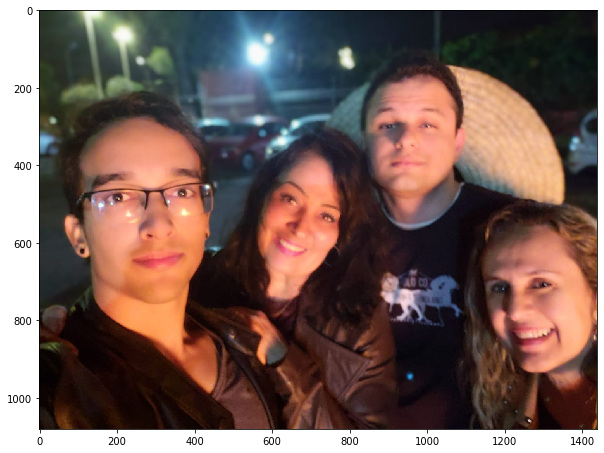

In [45]:
img = cv.imread("./test.jpg")
plt.rcParams['figure.figsize'] = 10, 10
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))

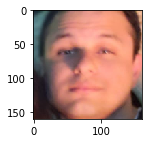

[0.17257555 0.82742447]


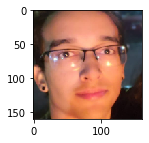

[0.9985298  0.00147019]


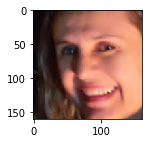

[0.17359978 0.82640016]


In [46]:
from face_detector import detect_faces_cascade

faces, _ = detect_faces_cascade(img)

plt.rcParams['figure.figsize'] = 2, 2
for face in faces:
    (x, y, w, h) = face

    croped_img = img[y:y+w, x:x+h]
    croped_img = 1/255 * cv.cvtColor(cv.resize(croped_img, (160, 160)), cv.COLOR_BGR2RGB)
    
    is_my_face = model.predict(np.expand_dims(croped_img, 0))[0]

    result = np.argmax(is_my_face)
    
    plt.imshow(croped_img)
    plt.show()
    print(is_my_face)

    if result == 0 and is_my_face[result] > 0.98:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)

    cv.rectangle(img, (x, y), (x+w, y+h), color, 2)  

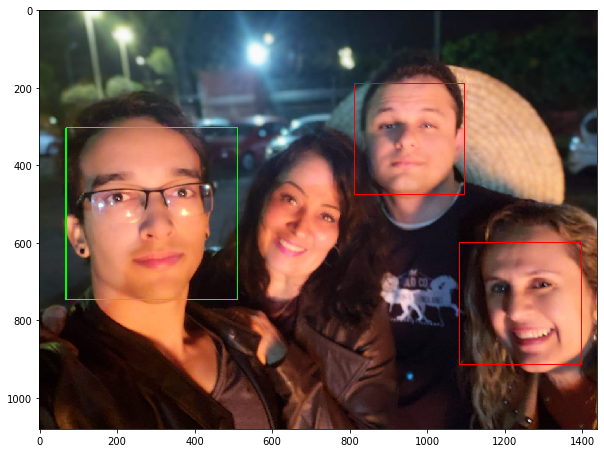

In [47]:
plt.rcParams['figure.figsize'] = 10, 10
plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))